In [ ]:
# default_exp seamcarving

# Import

In [ ]:
# export
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import numba
from pathlib import Path
from scipy import ndimage
import PIL
from skimage.transform import resize
import time

from cs371.utils import *

# SeamCarving

In [ ]:
filename = Path('data/LivingRoom.jpg')

In [ ]:
img = plt.imread(filename)
arr_orig = np.asarray(PIL.Image.fromarray(img).convert('L')).copy()
arr = arr_orig.copy()

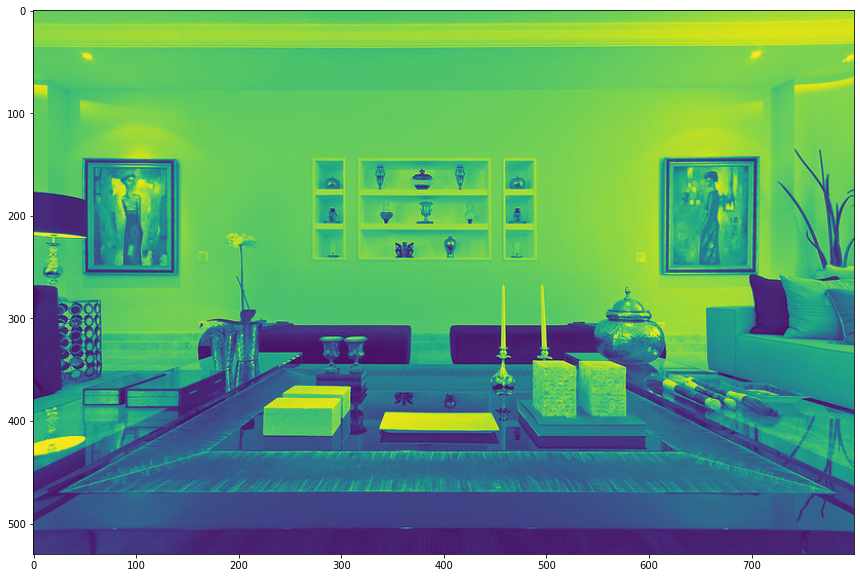

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(arr)

Get energy image; note there are different ways to do this

In [ ]:
arr_di, arr_dj = np.gradient(ndimage.gaussian_filter(arr, sigma=1))
arr_energy = abs(arr_di) + abs(arr_dj)

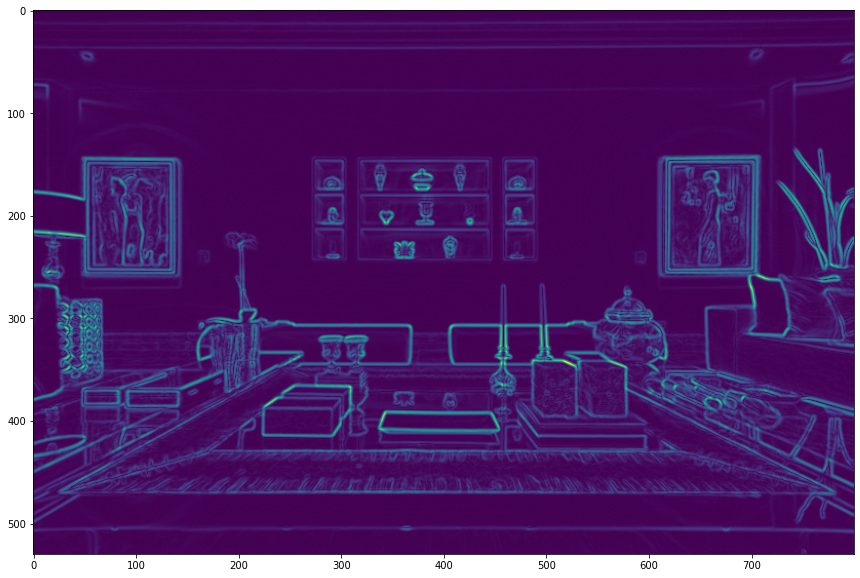

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(arr_energy)

In [ ]:
buf_path =      np.zeros_like(arr_energy)
buf_cost_prev = np.zeros(arr_energy.shape[1])
buf_cost =      np.zeros(arr_energy.shape[1])
buf_step =      np.zeros(3)
for i in range(1, arr_energy.shape[0]):
    for j in range(0, arr_energy.shape[1]):
        buf_step[:] = np.inf
        # Get step cost
        if j > 0:                     buf_step[0] = buf_cost_prev[j-1]
        buf_step[1] = buf_cost_prev[j]
        if j < arr_energy.shape[1]-1: buf_step[2] = buf_cost_prev[j+1]
        # Get cumulative cost and store optimal step
        buf_cost[j] = arr_energy[i, j] + min(buf_step)
        buf_path[i, j] = np.argmin(buf_step) - 1
    buf_cost_prev[:] = buf_cost[:]

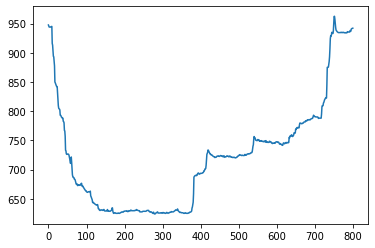

In [ ]:
plt.plot(buf_cost)

Speed up with numba

In [ ]:
# export
@numba.jit(nopython=True)
def _get_seam_cost(arr_energy, buf_path, buf_cost_prev, buf_cost, buf_step):
    for i in range(1, arr_energy.shape[0]):
        for j in range(0, arr_energy.shape[1]):
            buf_step[:] = np.inf
            # Get step cost
            if j > 0:                     buf_step[0] = buf_cost_prev[j-1]
            buf_step[1] = buf_cost_prev[j]
            if j < arr_energy.shape[1]-1: buf_step[2] = buf_cost_prev[j+1]
            # Get cumulative cost and store optimal step
            buf_cost[j] = arr_energy[i, j] + min(buf_step)
            buf_path[i, j] = np.argmin(buf_step) - 1
        buf_cost_prev[:] = buf_cost[:]

In [ ]:
buf_path[:] =      0
buf_cost_prev[:] = 0
buf_cost[:] =      0
buf_step[:] =      0

In [ ]:
_get_seam_cost(arr_energy, buf_path, buf_cost_prev, buf_cost, buf_step)

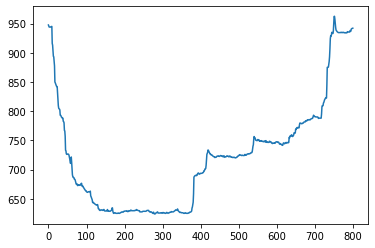

In [ ]:
plt.plot(buf_cost)

Backtrace path 

In [ ]:
seam = np.zeros(arr_energy.shape[0], dtype=np.int_)
seam[-1] = np.argmin(buf_cost)
for i in range(arr_energy.shape[0]-1, 0, -1):
    seam[i-1] = seam[i] + buf_path[i, seam[i]]

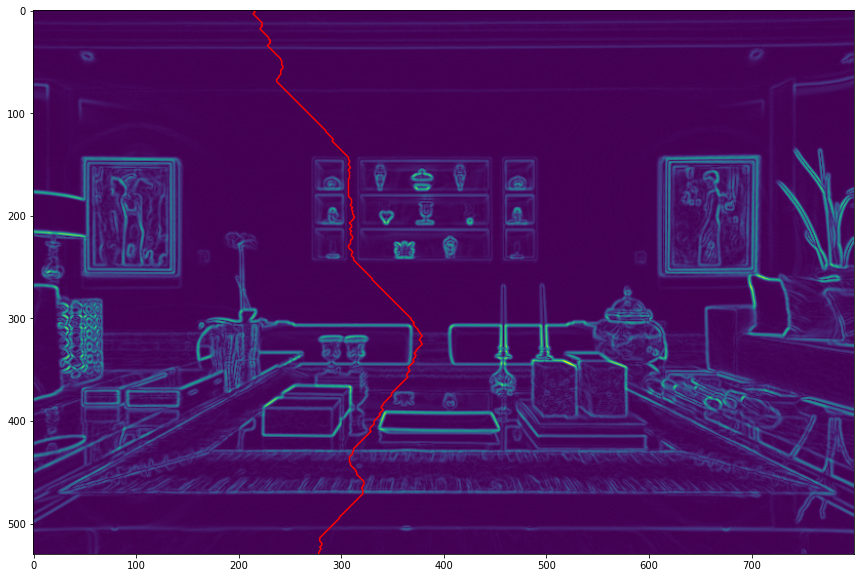

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(arr_energy)
plt.plot(seam, np.arange(len(seam)), '-r')

Speed up with numba

In [ ]:
# export
@numba.jit(nopython=True)
def _get_seam(seam, arr_energy, buf_path, buf_cost):
    seam[-1] = np.argmin(buf_cost)
    for i in range(arr_energy.shape[0]-1, 0, -1):
        seam[i-1] = seam[i] + buf_path[i, seam[i]]

In [ ]:
_get_seam(seam, arr_energy, buf_path, buf_cost)

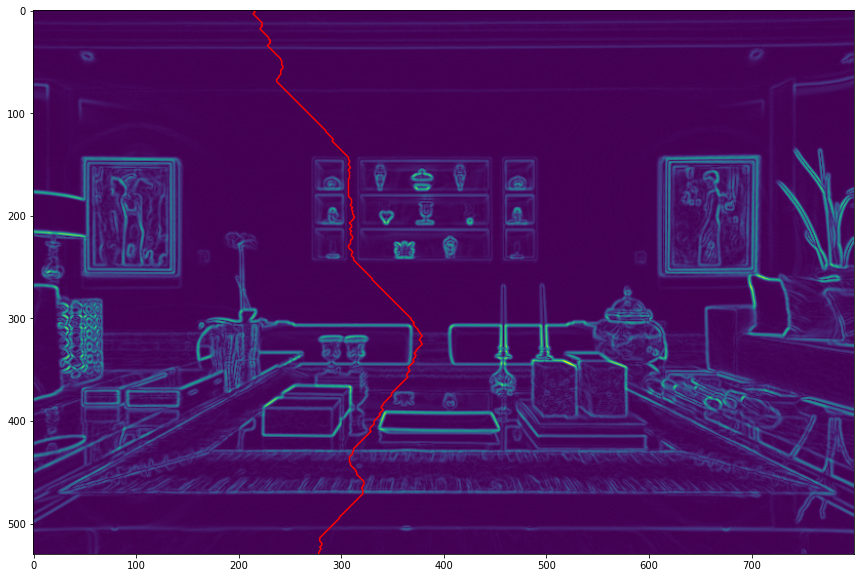

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(arr_energy)
plt.plot(seam, np.arange(len(seam)), '-r')

Remove seam

In [ ]:
# export
@numba.jit(nopython=True)
def _remove_seam(arr, seam):
    for i in range(arr.shape[0]):
        for j in range(seam[i], arr.shape[1]-1):
            arr[i, j] = arr[i, j+1]
    return arr[:, :-1]            

In [ ]:
arr = _remove_seam(arr, seam)

In [ ]:
arr.shape

(530, 799)

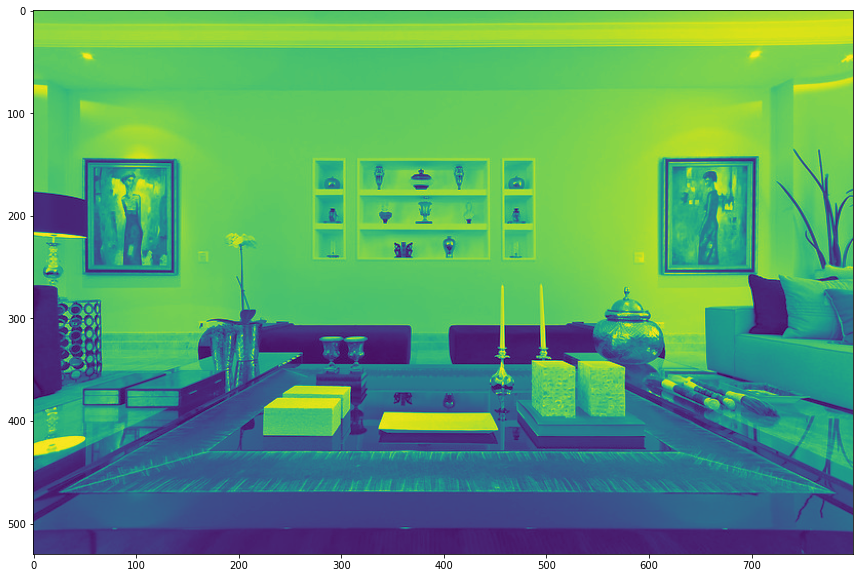

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(arr)

In [ ]:
# export
def seam_removal(arr, num_removal):
    for i in range(num_removal):
        # Get energy function
        arr_di, arr_dj = np.gradient(ndimage.gaussian_filter(arr, sigma=1))
        arr_energy = abs(arr_di) + abs(arr_dj)
        
        # Get seam cost
        buf_path =      np.zeros_like(arr_energy)
        buf_cost_prev = np.zeros(arr_energy.shape[1])
        buf_cost =      np.zeros(arr_energy.shape[1])
        buf_step =      np.zeros(3)
        _get_seam_cost(arr_energy, buf_path, buf_cost_prev, buf_cost, buf_step)
        
        # Get seam
        seam = np.zeros(arr_energy.shape[0], dtype=np.int_)
        _get_seam(seam, arr_energy, buf_path, buf_cost)
        
        # Remove seam
        arr = _remove_seam(arr, seam)
    
    return arr

In [ ]:
arr = seam_removal(arr, 300)

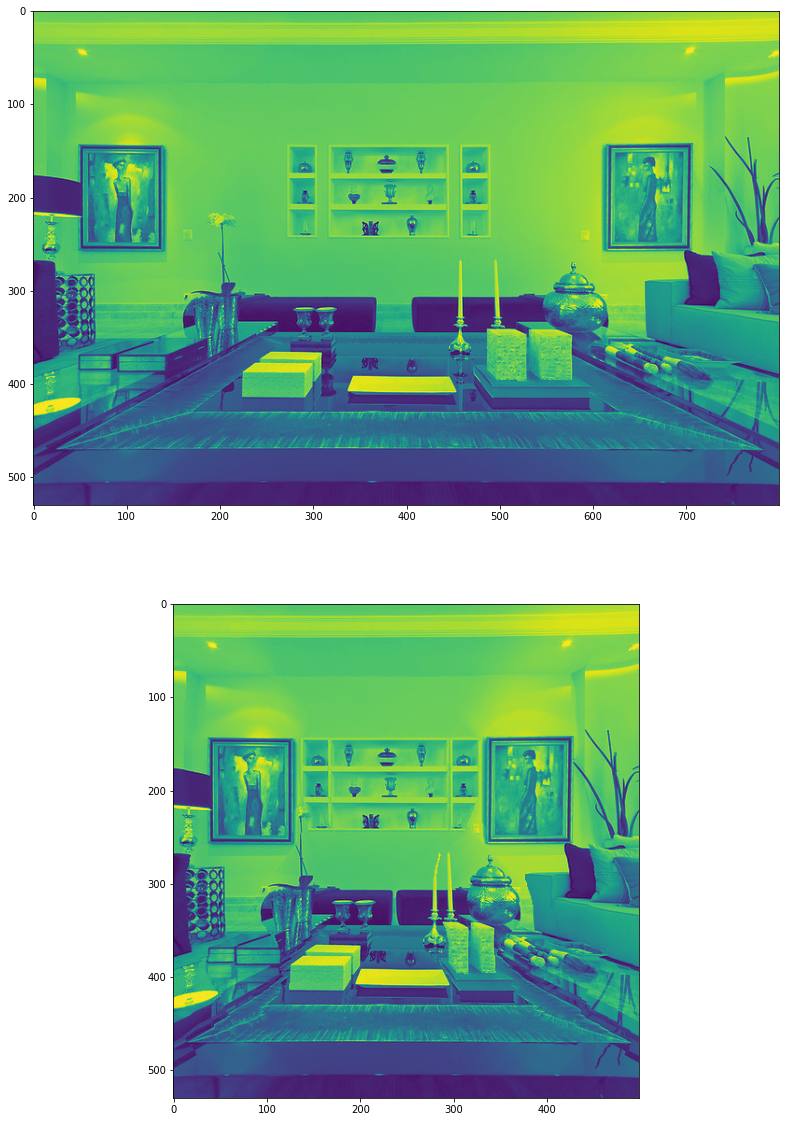

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 20))
axs[0].imshow(arr_orig)
axs[1].imshow(arr)

# Build

In [ ]:
build_notebook()

<IPython.core.display.Javascript object>

Converted seamcarving.ipynb.
